In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 31.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 23.1 MB/s 
     |████████████████████████████████| 1.8 MB 34.1 MB/s 
     |████████████████████████████████| 103 kB 63.6 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 3
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['set'] == 0, col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "point_of_interest"], train_data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,91.97%,8.03%
validation set - fold 0,94.30%,5.70%
development set - fold 1,93.15%,6.85%
validation set - fold 1,91.97%,8.03%
development set - fold 2,93.15%,6.85%
validation set - fold 2,91.97%,8.03%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0457445

CV-accuracy: 0.9842260740832387


In [ ]:
del train_data
gc.collect()

4

#Check Feature Importances

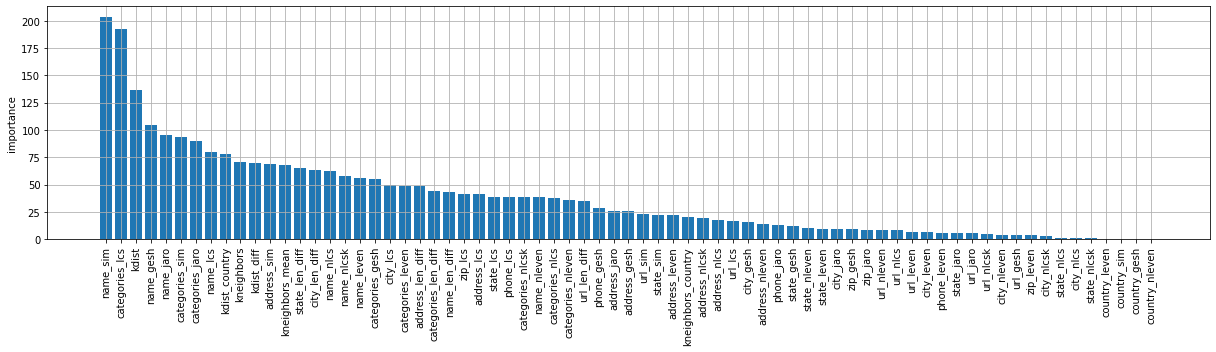

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 26.3 MB/s 
     |████████████████████████████████| 81 kB 9.4 MB/s 
     |████████████████████████████████| 210 kB 63.5 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 67.3 MB/s 
     |████████████████████████████████| 146 kB 53.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=98572ba4ff4b1267fc348f69d146183d854ca32de0a13b36c5c1b6ef6bc7d20e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-25 15:04:14,307] A new study created in memory with name: no-name-1305d38e-0348-4847-b0b1-bd28389bd3de
[I 2022-05-25 15:04:46,297] Trial 0 finished with value: 0.8153265438833801 and parameters: {'threshold': 0.4374565480618091}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.815327


[I 2022-05-25 15:05:08,987] Trial 1 finished with value: 0.8107815077657837 and parameters: {'threshold': 0.6216329328384306}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.810782


[I 2022-05-25 15:05:33,754] Trial 2 finished with value: 0.8145158502914515 and parameters: {'threshold': 0.4050990039410406}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.814516


[I 2022-05-25 15:05:58,416] Trial 3 finished with value: 0.7802431851234333 and parameters: {'threshold': 0.1576077865782668}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.780243


[I 2022-05-25 15:06:23,639] Trial 4 finished with value: 0.8058370739035859 and parameters: {'threshold': 0.27747442734912864}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.805837


[I 2022-05-25 15:06:44,998] Trial 5 finished with value: 0.7542852572449238 and parameters: {'threshold': 0.9004724488981278}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.754285


[I 2022-05-25 15:07:06,458] Trial 6 finished with value: 0.6613568565373292 and parameters: {'threshold': 0.9934237948621146}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.661357


[I 2022-05-25 15:07:30,210] Trial 7 finished with value: 0.8116607982126668 and parameters: {'threshold': 0.6053014741179824}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.811661


[I 2022-05-25 15:07:53,382] Trial 8 finished with value: 0.7814059598600379 and parameters: {'threshold': 0.8257518294963389}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.781406


[I 2022-05-25 15:08:17,499] Trial 9 finished with value: 0.8126034027147709 and parameters: {'threshold': 0.5867361096225865}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.812603


[I 2022-05-25 15:08:45,282] Trial 10 finished with value: 0.6646000897729837 and parameters: {'threshold': 0.0344982391191056}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.664600


[I 2022-05-25 15:09:11,201] Trial 11 finished with value: 0.8149842709493292 and parameters: {'threshold': 0.42016424065644353}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.814984


[I 2022-05-25 15:09:35,224] Trial 12 finished with value: 0.8144253425908871 and parameters: {'threshold': 0.4013771353592679}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.814425


[I 2022-05-25 15:10:00,018] Trial 13 finished with value: 0.8152259149347189 and parameters: {'threshold': 0.43116076293390176}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.815226


[I 2022-05-25 15:10:25,451] Trial 14 finished with value: 0.8006867758501248 and parameters: {'threshold': 0.24086164306389307}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.800687


[I 2022-05-25 15:10:48,378] Trial 15 finished with value: 0.815086374989034 and parameters: {'threshold': 0.5050506282833569}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.815086


[I 2022-05-25 15:11:11,946] Trial 16 finished with value: 0.7992677211886025 and parameters: {'threshold': 0.7338674788998735}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.799268


[I 2022-05-25 15:11:37,119] Trial 17 finished with value: 0.8071099275315164 and parameters: {'threshold': 0.28921159434177535}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.807110


[I 2022-05-25 15:12:00,291] Trial 18 finished with value: 0.8153117437943167 and parameters: {'threshold': 0.49714825712588884}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.815312


[I 2022-05-25 15:12:24,016] Trial 19 finished with value: 0.8010307646145925 and parameters: {'threshold': 0.7211610500854937}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.801031


[I 2022-05-25 15:12:46,910] Trial 20 finished with value: 0.8148335559032533 and parameters: {'threshold': 0.5163664632246868}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.814834


[I 2022-05-25 15:13:11,783] Trial 21 finished with value: 0.8118453988665527 and parameters: {'threshold': 0.3431346205899706}. Best is trial 0 with value: 0.8153265438833801.


CV: 0.811845


[I 2022-05-25 15:13:36,326] Trial 22 finished with value: 0.8154360142956864 and parameters: {'threshold': 0.4789055276745751}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.815436


[I 2022-05-25 15:13:59,215] Trial 23 finished with value: 0.8149937793803192 and parameters: {'threshold': 0.5091058106956147}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.814994


[I 2022-05-25 15:14:22,801] Trial 24 finished with value: 0.8033791598538188 and parameters: {'threshold': 0.702177165339177}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.803379


[I 2022-05-25 15:14:48,572] Trial 25 finished with value: 0.7850502530168193 and parameters: {'threshold': 0.17213712297016182}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.785050


[I 2022-05-25 15:15:11,334] Trial 26 finished with value: 0.8131970092198266 and parameters: {'threshold': 0.5709849317377427}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.813197


[I 2022-05-25 15:15:35,983] Trial 27 finished with value: 0.811664283585051 and parameters: {'threshold': 0.3409045730700414}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.811664


[I 2022-05-25 15:16:01,019] Trial 28 finished with value: 0.8078998321797255 and parameters: {'threshold': 0.658401371921323}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.807900


[I 2022-05-25 15:16:25,285] Trial 29 finished with value: 0.8154177163348721 and parameters: {'threshold': 0.4879724794044219}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.815418


[I 2022-05-25 15:16:51,067] Trial 30 finished with value: 0.7887296949717645 and parameters: {'threshold': 0.18490742920096948}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.788730


[I 2022-05-25 15:17:14,891] Trial 31 finished with value: 0.8154051702096828 and parameters: {'threshold': 0.4796073751312622}. Best is trial 22 with value: 0.8154360142956864.


CV: 0.815405


[I 2022-05-25 15:17:40,384] Trial 32 finished with value: 0.8155101871580961 and parameters: {'threshold': 0.46038258703041757}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815510


[I 2022-05-25 15:18:03,343] Trial 33 finished with value: 0.8155022508704126 and parameters: {'threshold': 0.45987195072648296}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815502


[I 2022-05-25 15:18:27,987] Trial 34 finished with value: 0.8136607820462237 and parameters: {'threshold': 0.3778589418064525}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.813661


[I 2022-05-25 15:18:51,934] Trial 35 finished with value: 0.8141973836265134 and parameters: {'threshold': 0.5440857386107839}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.814197


[I 2022-05-25 15:19:16,563] Trial 36 finished with value: 0.8154358976959195 and parameters: {'threshold': 0.4475980599824331}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815436


[I 2022-05-25 15:19:40,390] Trial 37 finished with value: 0.8079649584355815 and parameters: {'threshold': 0.6574791836568843}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.807965


[I 2022-05-25 15:20:03,895] Trial 38 finished with value: 0.8102096778656336 and parameters: {'threshold': 0.3228903162404658}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.810210


[I 2022-05-25 15:20:28,168] Trial 39 finished with value: 0.8154867034885019 and parameters: {'threshold': 0.4553372568219522}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815487


[I 2022-05-25 15:20:53,486] Trial 40 finished with value: 0.8011490414193053 and parameters: {'threshold': 0.24385378376536582}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.801149


[I 2022-05-25 15:21:16,554] Trial 41 finished with value: 0.8153960221856865 and parameters: {'threshold': 0.4457768908223392}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815396


[I 2022-05-25 15:21:41,089] Trial 42 finished with value: 0.8138620240559876 and parameters: {'threshold': 0.38329402922108324}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.813862


[I 2022-05-25 15:22:05,373] Trial 43 finished with value: 0.8137081690413305 and parameters: {'threshold': 0.5576173336693077}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.813708


[I 2022-05-25 15:22:28,471] Trial 44 finished with value: 0.815373698308613 and parameters: {'threshold': 0.4447755665632982}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815374


[I 2022-05-25 15:22:52,327] Trial 45 finished with value: 0.8110977034750413 and parameters: {'threshold': 0.6171804382985379}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.811098


[I 2022-05-25 15:23:16,516] Trial 46 finished with value: 0.8154013343073985 and parameters: {'threshold': 0.4435222306187953}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815401


[I 2022-05-25 15:23:41,028] Trial 47 finished with value: 0.8134258696712077 and parameters: {'threshold': 0.3724260135657538}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.813426


[I 2022-05-25 15:24:07,569] Trial 48 finished with value: 0.7328401618718 and parameters: {'threshold': 0.07621050440967692}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.732840


[I 2022-05-25 15:24:32,538] Trial 49 finished with value: 0.8078384515371687 and parameters: {'threshold': 0.2957245194194559}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.807838


[I 2022-05-25 15:24:55,718] Trial 50 finished with value: 0.8154820945158345 and parameters: {'threshold': 0.47109358678533536}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815482


[I 2022-05-25 15:25:20,173] Trial 51 finished with value: 0.8155001037418035 and parameters: {'threshold': 0.4609482780620779}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815500


[I 2022-05-25 15:25:44,004] Trial 52 finished with value: 0.8142622010015717 and parameters: {'threshold': 0.5402907896553223}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.814262


[I 2022-05-25 15:26:06,715] Trial 53 finished with value: 0.8154638135969656 and parameters: {'threshold': 0.4773348324945745}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815464


[I 2022-05-25 15:26:30,908] Trial 54 finished with value: 0.8145117121117813 and parameters: {'threshold': 0.40506233586286106}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.814512


[I 2022-05-25 15:26:54,689] Trial 55 finished with value: 0.8117071616397448 and parameters: {'threshold': 0.6043459894652677}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.811707


[I 2022-05-25 15:27:16,442] Trial 56 finished with value: 0.7896589821041827 and parameters: {'threshold': 0.7899500747975112}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.789659


[I 2022-05-25 15:27:40,225] Trial 57 finished with value: 0.8142280250160421 and parameters: {'threshold': 0.5426105018981918}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.814228


[I 2022-05-25 15:28:03,934] Trial 58 finished with value: 0.8128198231208412 and parameters: {'threshold': 0.5819921633033952}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.812820


[I 2022-05-25 15:28:27,600] Trial 59 finished with value: 0.8086786861099926 and parameters: {'threshold': 0.6492671526623113}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.808679


[I 2022-05-25 15:28:48,247] Trial 60 finished with value: 0.7157501280895197 and parameters: {'threshold': 0.9550393206941215}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.715750


[I 2022-05-25 15:29:12,457] Trial 61 finished with value: 0.8154796196996652 and parameters: {'threshold': 0.4733523630012251}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815480


[I 2022-05-25 15:29:35,156] Trial 62 finished with value: 0.8154955563803963 and parameters: {'threshold': 0.4736690082174009}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815496


[I 2022-05-25 15:29:59,349] Trial 63 finished with value: 0.8147131933439647 and parameters: {'threshold': 0.4113778366088942}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.814713


[I 2022-05-25 15:30:23,382] Trial 64 finished with value: 0.8149282929724865 and parameters: {'threshold': 0.5114761817739081}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.814928


[I 2022-05-25 15:30:46,288] Trial 65 finished with value: 0.8123355861423125 and parameters: {'threshold': 0.35191223419264195}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.812336


[I 2022-05-25 15:31:10,173] Trial 66 finished with value: 0.8155059849206889 and parameters: {'threshold': 0.46579564675234075}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815506


[I 2022-05-25 15:31:34,491] Trial 67 finished with value: 0.8149286425062283 and parameters: {'threshold': 0.4181057604794662}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.814929


[I 2022-05-25 15:31:56,976] Trial 68 finished with value: 0.8145856862742472 and parameters: {'threshold': 0.5290664716411988}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.814586


[I 2022-05-25 15:32:21,528] Trial 69 finished with value: 0.8101567572149829 and parameters: {'threshold': 0.32247689668517815}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.810157


[I 2022-05-25 15:32:45,566] Trial 70 finished with value: 0.8154703973359966 and parameters: {'threshold': 0.46844711134032874}. Best is trial 32 with value: 0.8155101871580961.


CV: 0.815470


[I 2022-05-25 15:33:09,736] Trial 71 finished with value: 0.8155113190530151 and parameters: {'threshold': 0.46031775593264684}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815511


[I 2022-05-25 15:33:32,670] Trial 72 finished with value: 0.8151038024286822 and parameters: {'threshold': 0.4239876140050779}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815104


[I 2022-05-25 15:33:56,546] Trial 73 finished with value: 0.8149848474417779 and parameters: {'threshold': 0.5085170349028829}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.814985


[I 2022-05-25 15:34:19,648] Trial 74 finished with value: 0.8138471168524554 and parameters: {'threshold': 0.383115324435188}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.813847


[I 2022-05-25 15:34:43,682] Trial 75 finished with value: 0.81549985571204 and parameters: {'threshold': 0.4591832052024405}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815500


[I 2022-05-25 15:35:07,420] Trial 76 finished with value: 0.8131362604075852 and parameters: {'threshold': 0.5740285812692901}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.813136


[I 2022-05-25 15:35:30,518] Trial 77 finished with value: 0.8127132824174086 and parameters: {'threshold': 0.3587563261769605}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.812713


[I 2022-05-25 15:35:54,480] Trial 78 finished with value: 0.8153917323304037 and parameters: {'threshold': 0.44646043537844643}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815392


[I 2022-05-25 15:36:18,763] Trial 79 finished with value: 0.8143058358066974 and parameters: {'threshold': 0.3969044366844769}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.814306


[I 2022-05-25 15:36:41,423] Trial 80 finished with value: 0.8153649751617478 and parameters: {'threshold': 0.4960088976261994}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815365


[I 2022-05-25 15:37:05,570] Trial 81 finished with value: 0.8155088163940895 and parameters: {'threshold': 0.45717862286073274}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815509


[I 2022-05-25 15:37:29,299] Trial 82 finished with value: 0.8145609162259813 and parameters: {'threshold': 0.5301058036540058}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.814561


[I 2022-05-25 15:37:53,500] Trial 83 finished with value: 0.815469953039898 and parameters: {'threshold': 0.45641304429070007}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815470


[I 2022-05-25 15:38:16,398] Trial 84 finished with value: 0.81515626649492 and parameters: {'threshold': 0.42636161249929944}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815156


[I 2022-05-25 15:38:40,983] Trial 85 finished with value: 0.8099496909910141 and parameters: {'threshold': 0.31945188565460136}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.809950


[I 2022-05-25 15:39:03,662] Trial 86 finished with value: 0.8154163371788675 and parameters: {'threshold': 0.4925900612183188}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815416


[I 2022-05-25 15:39:27,950] Trial 87 finished with value: 0.814163269522985 and parameters: {'threshold': 0.3933367538178716}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.814163


[I 2022-05-25 15:39:51,570] Trial 88 finished with value: 0.8137102190927996 and parameters: {'threshold': 0.5577622818747836}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.813710


[I 2022-05-25 15:40:15,835] Trial 89 finished with value: 0.8151685330771659 and parameters: {'threshold': 0.42728047540317315}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815169


[I 2022-05-25 15:40:38,538] Trial 90 finished with value: 0.8148826794962561 and parameters: {'threshold': 0.5143649191257516}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.814883


[I 2022-05-25 15:41:02,644] Trial 91 finished with value: 0.8153841746315666 and parameters: {'threshold': 0.4806322857122317}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815384


[I 2022-05-25 15:41:27,158] Trial 92 finished with value: 0.8154990317496742 and parameters: {'threshold': 0.4601593909735018}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815499


[I 2022-05-25 15:41:50,121] Trial 93 finished with value: 0.8154381681168921 and parameters: {'threshold': 0.45335654177317686}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815438


[I 2022-05-25 15:42:14,150] Trial 94 finished with value: 0.8154840502842134 and parameters: {'threshold': 0.461523263312838}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815484


[I 2022-05-25 15:42:38,483] Trial 95 finished with value: 0.8145539402184535 and parameters: {'threshold': 0.4059443994178359}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.814554


[I 2022-05-25 15:43:03,032] Trial 96 finished with value: 0.8132646087840673 and parameters: {'threshold': 0.36944388038730697}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.813265


[I 2022-05-25 15:43:25,430] Trial 97 finished with value: 0.8119068903074428 and parameters: {'threshold': 0.6012191244364739}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.811907


[I 2022-05-25 15:43:49,285] Trial 98 finished with value: 0.8153650467115449 and parameters: {'threshold': 0.4959800528386538}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.815365


[I 2022-05-25 15:44:13,424] Trial 99 finished with value: 0.8137245192073599 and parameters: {'threshold': 0.5579786977745418}. Best is trial 71 with value: 0.8155113190530151.


CV: 0.813725


In [ ]:
threshold = study.best_params['threshold']
threshold

0.46031775593264684

In [ ]:
study.best_value

0.8155113190530151

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.815511


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,147757.000000,147757.000000,143628.000000,143628.000000,138390.000000,152167.000000,152167.0,152167.000000,152167.000000,152167.000000,...,152167.000000,152163.00000,152163.000000,152163.000000,152163.000000,152167.000000,152163.000000,152163.00000,152163.00000,152167.000000
mean,0.006290,6.209939,0.003499,6.259462,0.427080,6.511668,1.0,0.259528,0.411664,16.360210,...,0.998719,0.99887,0.002320,0.998859,1.997739,0.000026,0.001160,0.99887,0.99887,0.173399
std,0.046029,5.188395,0.022798,5.215816,2.368743,5.263977,0.0,0.306263,0.250016,9.460763,...,0.035775,0.03296,0.067251,0.033395,0.065921,0.005127,0.033625,0.03296,0.03296,0.139490
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000025
25%,0.000435,2.000000,0.000325,2.000000,0.005939,2.000000,1.0,0.000000,0.210526,10.000000,...,1.000000,1.00000,0.000000,1.000000,2.000000,0.000000,0.000000,1.00000,1.00000,0.045107
50%,0.001097,4.000000,0.000841,4.000000,0.056220,5.000000,1.0,0.000000,0.400000,15.000000,...,1.000000,1.00000,0.000000,1.000000,2.000000,0.000000,0.000000,1.00000,1.00000,0.144214
75%,0.003068,10.000000,0.002355,10.000000,0.322220,10.000000,1.0,0.508232,0.592593,22.000000,...,1.000000,1.00000,0.000000,1.000000,2.000000,0.000000,0.000000,1.00000,1.00000,0.287807
max,4.310371,19.000000,2.388985,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.00000,2.000000,1.000000,2.000000,1.000000,1.000000,1.00000,1.00000,0.460316


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
995761,E_bf6326fd1875f3,E_8baff30435106a,0.000160,1.0,P_e41e93777a3699,0.000120,1.0,0.337462,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.193487
5873039,E_505d8a43d0d0a3,E_eb5f3106ff6454,0.002114,10.0,P_c2b5d02baedb97,0.002109,11.0,0.002066,10.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.062950
5156441,E_0e447d69e9b657,E_15d21998bb6f95,0.000739,9.0,P_2df67bfb407545,0.000469,7.0,0.576071,8.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.019871
6217969,E_eb68fc35313243,E_b18f123d6e13fc,0.003133,10.0,P_558946082bbb03,0.002293,10.0,0.366463,10.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.146094
11471359,E_2c4800a6a08931,E_e1e3f4f3dea83c,NaN,NaN,P_eaf6d99ea4a4a1,0.000023,7.0,NaN,7.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.008423
11177408,E_a1019ce6c31fc9,E_c2f99f7ab9bcb5,0.019878,19.0,P_987c699ebde4fc,0.016132,19.0,0.232181,19.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.016341
3024818,E_4fd3a5d3e0c307,E_0a93309d88b5d4,0.000553,5.0,P_57863d4f8da319,0.000548,5.0,0.007996,5.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.290868
841937,E_7a66a246fc3f78,E_c35a277f7e6676,0.000412,1.0,P_a20e02f54d18d0,0.000297,1.0,0.386521,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.004332
2154559,E_c878f422235e70,E_ffb69f96f1899f,0.002191,3.0,P_95f15e4c776d39,0.002163,3.0,0.013059,3.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.332947
1226508,E_2750294f4bb2f7,E_9acf8304f0627e,0.000470,2.0,P_d07b22b3d198cd,0.000418,2.0,0.124728,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.182409


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
451600,E_657a0d2b643b04,Воспитательный центр Шк6,59.448009,32.033249,NaN,NaN,NaN,NaN,RU,NaN,NaN,High Schools,P_22815584730ea2,4,1.0
539445,E_793b515dc0e9eb,Кабинет Моисеевой😞🔫😱😣,59.448215,32.033415,Строителей 12,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_22815584730ea2,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
555474,E_7cd58ad251b4ca,Oh La La Food Court,-5.422273,105.251237,Jl. Wolter Monginsidi,Bandar Lampung,Lampung,NaN,ID,NaN,NaN,Cafés,P_052e8fd2a34bc9,4,1.0
673866,E_975ff3f20839a3,OH LA LA,-5.418755,105.247831,NaN,NaN,NaN,NaN,ID,NaN,NaN,Coffee Shops,P_052e8fd2a34bc9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
45302,E_0a25265e2a0588,Akıncı Beach Club,39.118456,26.856544,NaN,Dikili,İzmir,NaN,TR,NaN,NaN,"Beaches, Beach Bars, Cafés",P_68e157b65ee7b9,1,1.0
842935,E_bd4dedf39c1abc,Bankacılar Cafe & Bar,39.118540,26.856498,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Beach Bars, Pubs",P_68e157b65ee7b9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
122756,E_1b85bf7dd54123,7-Eleven (เซเว่น อีเลฟเว่น),14.442755,100.132724,Highway Number 340,Suphan Buri,Changwat Suphan Buri,72000,TH,http://www.7eleven.co.th,NaN,Convenience Stores,P_c4391c344d61ef,1,1.0
591636,E_84fc9dcc77f845,7-Eleven ปตท.หลักเมือง,14.442688,100.132656,NaN,Tha Rahat,Suphan Buri,NaN,TH,NaN,NaN,"Gas Stations, Convenience Stores",P_c4391c344d61ef,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
293083,E_41cf654d252241,Car Park@Topland Plaza,16.821417,100.264335,NaN,Nai Muang,Phitsanulok,NaN,TH,NaN,NaN,Parking,P_01eb6b2159415a,1,1.0
1036160,E_e8cc50314d3931,Parking Topland Plaza,16.821672,100.264471,NaN,NaN,NaN,NaN,TH,NaN,NaN,Parking,P_01eb6b2159415a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
192080,E_2b16d09ca0b709,Utah Highway Patrol,40.990748,-111.897105,NaN,Farmington,UT,NaN,US,NaN,NaN,Police Stations,P_c0112cd316d297,1,1.0
394093,E_588cf97f27e520,Utah Driver License Division,40.990909,-111.897239,631 Lagoon Dr,Farmington,UT,84025,US,NaN,8019654437,Government Buildings,P_c0112cd316d297,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
48526,E_0ad9efa286f898,شورت بيج و سليفارداو ونظاره ريبان (نادي إوكسجين),29.328109,47.983989,NaN,NaN,NaN,NaN,KW,NaN,NaN,Gyms,P_fd0d71e40f437c,3,1.0
1020033,E_e52aee0a585c6d,Oxygen Gym,29.328153,47.984242,NaN,Adailiya,Al Kuwayt,NaN,KW,NaN,NaN,Gyms,P_fd0d71e40f437c,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
701216,E_9d7cbd3955028d,Kantor imigrasi jaksel,-6.292540,106.786847,Jln raya lebak bulus,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_bd86264f20d140,4,1.0
716003,E_a0d3cf5dde5b57,Imigrasi kelas 1 jakarta selatan jl.Tb.simatupang,-6.290472,106.787767,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Government Buildings,P_bd86264f20d140,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
391324,E_57eb1e65ecd1f3,Лицей 4,57.981065,56.208104,"ул. Танкистов, 56",Пермь,Пермский край,614022,RU,http://lizey4.narod.ru,3422250417,"Schools, General Colleges & Universities, High...",P_77566f5ad8071f,4,1.0
409043,E_5bebd0063316b1,28 Кабинет)0,57.981140,56.209458,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_77566f5ad8071f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
862366,E_c1b36ef168a3bc,Uzungol,40.618190,40.292291,Uzungol,Trabzon,NaN,61400,TR,NaN,NaN,"National Parks, Lakes",P_c1076f7b9f955d,4,1.0
867982,E_c2f88b249aa264,Uzungöl,40.619589,40.298703,"Çaykara, Trabzon","Çaykara, Trabzon",NaN,61000,TR,NaN,NaN,Lakes,P_c1076f7b9f955d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
804782,E_b4b6f64faab49b,JC Penney,40.429863,-79.796925,NaN,Monroeville,PA,NaN,US,NaN,NaN,Department Stores,P_585982fa96b142,2,1.0
1128365,E_fda46e5ee92732,Jcpenney,40.429428,-79.796822,NaN,Monroeville,PA,NaN,US,NaN,NaN,Buildings,P_585982fa96b142,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
158487,E_23835cd2393bb1,Залы 1-7 Галереи,55.741389,37.620902,NaN,Москва,Москва,119017,RU,NaN,NaN,Art Galleries,P_fa357d9d9f6312,2,1.0
1083953,E_f393f9ec9edbce,Государственная Третьяковская галерея / Tretya...,55.741363,37.620700,"Лаврушинский пер., 10",Москва,Москва,119017,RU,https://www.tretyakovgallery.ru,+74959570727,Art Museums,P_fa357d9d9f6312,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
510145,E_72afd502249961,Кабинет физики,60.089737,29.950185,Школа №556,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_4455402e0d492c,4,1.0
632837,E_8e490f4c923b3f,География 🇨🇳,60.089371,29.949523,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_4455402e0d492c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
686847,E_9a4130a74888f6,TİMSAH ARENA,40.210536,29.009027,NaN,NaN,NaN,NaN,TR,NaN,NaN,Festivals,P_581acf4c39aa29,4,1.0
1007609,E_e2544fee4b1824,Timsah Arena,40.210351,29.009025,Dikkaldırım Bursa,NaN,NaN,NaN,TR,NaN,NaN,"Soccer Stadiums, Stadiums",P_581acf4c39aa29,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
260093,E_3a661cb32b99ee,Учебный центр МТС,55.814897,37.576001,"Дмитровское ш., 9",Москва,Москва,NaN,RU,NaN,NaN,Offices,P_31d5733dea349c,4,1.0
744758,E_a752ed870f3151,МАСТЕР КЛАСС ТВОРЧЕСТВО,55.813908,37.578764,"Дмитровское ш., 9, Москва",Москва,NaN,NaN,RU,NaN,NaN,Convention Centers,P_31d5733dea349c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
393802,E_587c08fc65445e,JJ/History/B1,43.254483,-79.877612,NaN,NaN,NaN,NaN,CA,NaN,NaN,Historic Sites,P_1abde81124aa4a,4,1.0
976125,E_db46d02481b04c,JJ/History/O,43.254479,-79.877689,NaN,NaN,NaN,NaN,CA,NaN,NaN,Historic Sites,P_1abde81124aa4a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
348107,E_4e3927e50427c3,South Point Room 480,36.010845,-115.177021,NaN,Las Vegas,NV,NaN,US,NaN,NaN,Hotels,P_e318ae89292ad9,4,1.0
1123012,E_fc73985be4a714,South Point - Room 1781,36.011325,-115.179018,NaN,Las Vegas,NV,89123,US,NaN,NaN,Hotels,P_e318ae89292ad9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
361745,E_514a8411f1da13,Кабинет Информатики,59.83188,30.156009,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auditoriums,P_9d8755641360b5,4,1.0
546162,E_7abd062cf74464,у Пановой,59.83115,30.156727,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_9d8755641360b5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
131420,E_1d75cf887ab419,Boğaz Köprüsünün Ortasında,41.048127,29.03155,NaN,NaN,NaN,NaN,TR,NaN,NaN,Nightclubs,P_fbe61733fcdebe,4,1.0
1078534,E_f25f1b7e9335ad,İstanbul Üstü,41.047328,29.03178,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bridges,P_fbe61733fcdebe,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
489058,E_6dee9cad23b53d,BDL,41.920216,-72.669601,1 Bradley International Airport Con,Windsor Locks,CT,06096,US,NaN,NaN,"Airports, Airport Lounges",P_4572de0f3ee440,4,1.0
954616,E_d674fd9ea40eeb,bradley international pick up,41.924897,-72.672142,NaN,Windsor Locks,CT,NaN,US,NaN,NaN,Airports,P_4572de0f3ee440,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
338052,E_4bfc6af0ef6eea,AEON MALL BSD CITY,-6.268807,106.630614,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9ca6f5784b5b37,4,1.0
585530,E_839de870ea7a04,Aeon Mall,-6.266988,106.625946,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9ca6f5784b5b37,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
195622,E_2be3a8e2d599ff,X IPA 10 St. Thomas 1 Medan,3.588614,98.668480,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_f3e552b97439d3,4,1.0
600434,E_86f089fda15a16,SMA St.Thomas 1,3.588893,98.668642,Jl.S.Parman no 109,Medan,Sumatera Utara,NaN,ID,NaN,NaN,NaN,P_f3e552b97439d3,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
431793,E_610cd7c47dc476,Beet Goalhigandu,4.172944,73.511386,NaN,NaN,NaN,NaN,MV,NaN,NaN,Metro Stations,P_54ab4b90db0a60,4,1.0
751410,E_a8cce595a30128,Beet dive bar,4.173105,73.511306,NaN,NaN,NaN,NaN,MV,NaN,NaN,Dive Bars,P_54ab4b90db0a60,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
222646,E_31ffec0e3f861c,Burger King Buaran,-6.226869,106.923816,Jl.Raya DR.Soekamto,Buaran,NaN,NaN,ID,NaN,NaN,Burger Joints,P_b10362f8d22a5d,4,1.0
971808,E_da4c308c6b2f6c,Burger King,-6.227333,106.923041,NaN,Jakarta Timur,DKI Jakarta,NaN,ID,NaN,NaN,Fast Food Restaurants,P_b10362f8d22a5d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
12737,E_02e34b3ba4d467,Phoenix Sky Harbor International Airport (PHX),33.435624,-112.003066,3400 E Sky Harbor Blvd,Phoenix,AZ,85034,US,http://www.skyharbor.com,6022733300,Airports,P_d22526d2b9e019,4,1.0
357533,E_505c9e449e8701,De Plane De Plane,33.433743,-112.008190,PHX Tarmac,Phoenix,AZ,85034,US,NaN,NaN,Airports,P_d22526d2b9e019,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
433848,E_6186bd58865256,La Casa De Platanito Show,19.396589,-99.175492,NaN,NaN,NaN,NaN,MX,NaN,NaN,Residential Buildings (Apartments / Condos),P_271a5682677b49,1,1.0
895711,E_c92e8c6a13d455,El tío Platanito Show,19.396820,-99.175459,NaN,NaN,NaN,NaN,MX,NaN,NaN,Residential Buildings (Apartments / Condos),P_271a5682677b49,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
123798,E_1bc10432443388,Room6309@ite College West,1.374838,103.751435,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_70493458f51142,4,1.0
995138,E_df8e83585b071a,Room 1602,1.374595,103.751914,1 Choa Chu Kang Grove,Singapore,Singapore,688236,SG,NaN,+6564111022,College Classrooms,P_70493458f51142,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
591065,E_84da5b6d5b3088,ÆON,-6.304947,106.646439,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9ca6f5784b5b37,4,1.0
830616,E_ba85cfd9b3bf5d,AEON Mall,-6.300153,106.648259,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9ca6f5784b5b37,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
333550,E_4af98ed417e751,Americanas Express,-22.759944,-43.446008,"R. Cel. Francisco Soares, 202",Nova Iguaçu,RJ,26220-032,BR,http://www.americanas.com.br,+5521974622630,"Convenience Stores, Department Stores",P_523ab3c1a7b944,2,1.0
850394,E_befa5bef9cec9d,Lojas Americanas,-22.760480,-43.446008,Rua Coronel Francisco Soares 2,NOVA IGUAÇU,RJ,26220-032,BR,http://www.todomundovai.com.br,NaN,Department Stores,P_523ab3c1a7b944,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
303225,E_44174f5490ec28,11th Green,33.782037,-84.328888,DHGC,Atlanta,GA,30307,US,NaN,NaN,Golf Courses,P_8c9be8e6945ced,4,1.0
915268,E_cd99afdc215c32,2nd Green,33.782061,-84.329255,Clifton Rd,Atlanta,GA,30307,US,NaN,NaN,Golf Courses,P_8c9be8e6945ced,4,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,71154.000000,71154.000000,61176.000000,61176.000000,59374.000000,72349.000000,72349.0,72349.000000,72349.000000,72349.000000,...,72349.000000,72345.000000,72345.000000,72345.000000,72345.000000,72349.0,72345.000000,72345.000000,72345.000000,72349.000000
mean,0.066760,5.501307,0.003614,4.516608,0.406861,5.715870,0.0,0.535079,0.569631,12.581542,...,0.990781,0.991582,0.017237,0.991564,1.983164,0.0,0.008618,0.991582,0.991582,0.681726
std,0.694959,5.585606,0.021617,4.865399,1.731462,5.634147,0.0,0.380946,0.275071,9.364413,...,0.095574,0.089297,0.181893,0.090126,0.178595,0.0,0.090946,0.089297,0.089297,0.146979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.460320
25%,0.000345,1.000000,0.000229,1.000000,0.007697,1.000000,0.0,0.000000,0.363636,5.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.552908
50%,0.001144,3.000000,0.000656,2.000000,0.066507,3.000000,0.0,0.620190,0.594595,11.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.664944
75%,0.005404,9.000000,0.002154,6.000000,0.314941,9.500000,0.0,0.870747,0.785714,18.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.799904
max,61.893059,19.000000,1.531567,19.000000,99.538619,19.000000,0.0,1.000000,1.000000,60.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999991


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
641346,E_2041be864e5703,E_52831001c1b9b8,0.003396,1.0,P_178fe27ef8ce5d,0.003394,1.0,0.000784,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.759280
1022555,E_cb8ac078f16eda,E_2da7f557057adf,0.000873,1.0,P_e4186514f4f6a1,0.000375,1.0,1.324897,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.599645
10708608,E_ce488ba13859b5,E_30a7c920ebb4f4,0.366991,18.0,NaN,NaN,NaN,NaN,18.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.708562
1503219,E_a38e92ca526f3b,E_d39454261416be,0.000273,2.0,P_114384cd192228,0.000238,2.0,0.145907,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.875308
5880136,E_5381d032fc830f,E_63971ceb1fb446,0.213029,10.0,NaN,NaN,NaN,NaN,10.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.733623
10649908,E_b3d2f78f085c73,E_ba8795d53ec23d,0.006562,18.0,P_4e8f293a7ae1b2,0.006561,18.0,0.000065,18.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.751359
2778503,E_e10029a5e4ac3f,E_d33d5b0a2272b1,0.001705,4.0,P_a2ff38b272af58,0.001239,4.0,0.375764,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.896836
2433574,E_45ff9a77815583,E_ea8552d105349e,0.001557,4.0,P_d4c110b814ac04,0.001555,4.0,0.001034,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.665771
1129367,E_fbc13716326bd4,E_a411ad36c0bd89,0.001839,1.0,P_d3630bcbc7d43d,0.001103,1.0,0.667283,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.542704
7178474,E_9b1b0f195998fd,E_aeb5efc50b9de5,0.006459,12.0,P_6939fcaf8902d7,0.006291,13.0,0.026643,12.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.690441


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
89800,E_14204178bb98d9,bagno 28a,44.068345,12.583490,Adriatic Sea,Rimini,NaN,NaN,IT,NaN,NaN,Beaches,P_0d031de96ae10c,0,1.0
305747,E_44a89e3567276e,Bagno 25 Aldo,44.069250,12.582459,Lungomare Claudio Tintori 30,Rimini,Emilia Romagna,47921,IT,http://www.spiaggiarimini.net/stabilimento/25,+39054150597,Beaches,P_025eff142a3fa2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
60207,E_0d78ac9669f7f9,Starbucks (inside Stratosphere),36.143079,-115.157868,NaN,Las Vegas,NV,NaN,US,NaN,NaN,Coffee Shops,P_387f53c24e1183,2,1.0
355597,E_4febf1a8bfefde,Starbucks,36.138258,-115.165366,2880 Las Vegas Blvd S,Las Vegas,NV,89109,US,http://www.starbucks.com,+18774219062,Coffee Shops,P_93260c9bde19c5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
461425,E_67a97c3ff68ad0,Carrefour Market Ferri̬res d'aunis,46.227200,-0.866140,rue de la Juillerie Les Balotes,FERRIERES D'AUNIS,NaN,NaN,FR,http://www.carrefour.fr/magasin/market-ferrier...,+33546673701,Grocery Stores,P_c15a46e04daa2d,1,1.0
1090807,E_f522a52baf8c02,AXA Assurance Seguin-daguze,46.464244,-0.800672,74 Rue de la République,Fontenay-le-Comte,Pays de la Loire,85200,FR,https://axa.fr,+33251501130,NaN,P_093167af6c953a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
444708,E_63f3456023d129,SDN Karang Jangkong,-8.612472,116.213699,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fbebf966faaa2e,1,1.0
1127228,E_fd631b4e0868b7,IT Room RSUD dr. R. Soedjono,-8.650553,116.527040,"Jl. Professir M. Yamin, SH",Selong,West Nusa Tenggara,83611,ID,NaN,NaN,Housing Developments,P_d161a9d97258ba,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
33533,E_0782438e2ba58e,Аптека ВИТА Экспресс,53.397688,49.512569,"Вокзальная улица, 24",Жигулёвск,NaN,NaN,RU,https://vitaexpress.ru,+78007550003,Pharmacies,P_c3ce6666cc3877,0,1.0
947979,E_d4ee8169c3896f,Таблеточка,53.509853,49.436717,"ул. Мира, 101",Tolyatti,Samarskaya Oblast’,445054,RU,NaN,8482217121,Pharmacies,P_8a783298d2cf6a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
595592,E_85df3641e7c479,Taubers Unterwirt Aktiv & Vitalhotel,46.669005,11.599905,Via Josef Teiser 2,Feldthurns,Alto Adige,39040,IT,NaN,+390472855225,NaN,P_bd82902e5b8a1c,1,1.0
789195,E_b144327532e2c4,Confine I/A - Brennero,46.886529,11.476763,NaN,Brenner,Trentino-Alto Adige/Südtirol,39041,IT,NaN,NaN,Border Crossings,P_b2623c4bbee181,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
86809,E_1371100557aae1,Carl's Jr,33.787551,-117.830339,NaN,Orange,CA,NaN,US,NaN,NaN,Fast Food Restaurants,P_f6a3b3b51760c5,1,1.0
304535,E_446456f9fb4dc2,Carl's Jr. / Green Burrito,33.787373,-117.815707,3510 E Chapman Ave,Orange,CA,92869,US,https://www.carlsjr.com,7146333450,"Fast Food Restaurants, Burger Joints",P_05430d8ed38b82,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
187349,E_2a08dfe6bf429d,Paynawen Beach Resort,15.318945,119.973712,NaN,Iba,Zambales,2201,PH,NaN,NaN,"Resorts, Beaches",P_aac8b196e37184,1,1.0
294276,E_421703141f2010,Sand Valley Beach Resort,15.326316,119.975620,NaN,Iba,Zambales,NaN,PH,NaN,NaN,Beaches,P_16ba210988efd6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
609277,E_88f7d04861dde7,cafe ORIGINAL,37.549050,126.919215,마포구 독막로7길 27,서울특별시,NaN,NaN,KR,NaN,8223228166,Cafés,P_6f4008df01baea,0,1.0
1128759,E_fdb87c85c0cb59,cafe 5st★,37.549716,126.920402,NaN,NaN,NaN,NaN,KR,NaN,NaN,Cafés,P_7bb5819383e741,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
691241,E_9b3fb6b39a4aab,Mubarak Hospital Ward 20,29.327649,48.035551,NaN,NaN,NaN,NaN,KW,NaN,NaN,Hospitals,P_a6b509720fd7ee,0,1.0
926741,E_d02a221087f37f,mubarak hospital,29.324677,48.034617,NaN,NaN,NaN,NaN,KW,NaN,NaN,Hospitals,P_e0781f8b0a8975,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
42670,E_098a22cfb74785,"Taisel H Losada, PSYD",42.367726,-83.085475,2799 W Grand Blvd # K13,Detroit,MI,48202,US,https://www.henryford.com/physician-directory/...,+18004367936,Doctor's Offices,P_ca79e35d39aa7e,2,1.0
1063735,E_ef116ab1da078e,"Lisa L Allenspach, MD",42.367993,-83.085537,2799 W Grand Blvd # K16,Detroit,MI,48202,US,https://www.henryford.com/physician-directory/...,+18004367936,Doctor's Offices,P_32e1e42d6e40c3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
191474,E_2af6d20df76127,İstanbul Üniversitesi M7 Amfisi,41.014384,28.962465,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Classrooms,P_59328e31c95b2f,0,1.0
898761,E_c9e494cf8da7ea,Istanbul Universitesi Hukuk Fakultesi Calisma ...,41.013872,28.962675,NaN,NaN,NaN,NaN,TR,NaN,NaN,Law Schools,P_27a410f5ea72af,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
326080,E_495072e945d492,Restaurante Alcateia,41.803948,-6.761196,Rua do Loreto,Bragança,NaN,NaN,PT,NaN,NaN,Restaurants,P_cdb043fcdd65f9,0,1.0
861825,E_c1945af1e2e5c1,Bar Torregamones,41.485112,-6.178080,NaN,Torregamones,Castille and León,NaN,ES,NaN,NaN,"Tapas Restaurants, Cafés, Bars",P_cea56bb33e3036,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
231458,E_33f4928b28d198,pizza17,36.346128,-119.320069,NaN,Visalia,CA,93291,US,NaN,NaN,Pizza Places,P_8ca54406128e02,0,1.0
430923,E_60d747b2ef252f,pizza16,36.346128,-119.320069,NaN,Visalia,CA,93291,US,NaN,NaN,Pizza Places,P_aeb1ee3eef758e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
120534,E_1b07b67350aae0,Yomart KPGS Cikajang,-7.365109,107.814936,Jalan Cibodas Cikajang,Garut,West Java,NaN,ID,NaN,NaN,Department Stores,P_d45df0a6bb9712,0,1.0
774453,E_adf2cd5b65ad05,KPGS Cikajang,-7.365174,107.814439,Jl. Raya Cikajang,Garut,NaN,NaN,ID,NaN,NaN,NaN,P_c7feb01cb35aa6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
438450,E_6289787d054b5b,Ziraat Bankası Paramatik,36.834427,36.226830,Dörtyol Çarsı,Dörtyol,NaN,NaN,TR,NaN,NaN,Banks,P_b7856324cbc2b8,2,1.0
1119074,E_fb94b3e120fea7,Türkiye İş Bankası,36.836810,36.224187,NaN,NaN,NaN,NaN,TR,NaN,NaN,Banks,P_f21b83e56c660a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
468992,E_6965b6f9990ea3,Max3 Store Mal Kelapa Gading 1,-6.158785,106.906421,Jl. Kelapa Gading Boulevard Blok M,Jakarta,Indonesia,14240,ID,NaN,NaN,NaN,P_eb58fc436fc357,0,1.0
909643,E_cc5aa61f528625,Gramedia Mal Kelapa Gading,-6.159454,106.906894,NaN,NaN,NaN,NaN,ID,NaN,NaN,Bookstores,P_7b2315d508048d,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
85965,E_13413e84f2c9ee,Resor Tuban Tropis,-6.903592,112.043209,Jl Basuki Rachmad no.3,TUBAN,"East Java, Indonesia",NaN,ID,NaN,062356325800,"Hotels, Hotel Bars",P_22a58e043b87f3,1,1.0
1022500,E_e5bf6ce0b548de,RM jaya utama,-6.830115,111.997960,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_f02c5b588bd13a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
627295,E_8d0cca16813863,Axis Bank ATM,22.511648,88.26622,Axis Bank Atm,South 24 Parganas,West Bengal,700142,IN,https://branch.axisbank.com/axis-bank-bbt-road...,+9118604195555,ATMs,P_6ae2fa2fdcaf3f,0,1.0
663037,E_94f8a3d03e8686,Axis Bank ATM,22.507860,88.26339,Axis Bank Atm,South 24 Parganas,West Bengal,700140,IN,https://branch.axisbank.com/axis-bank-nungi-st...,+919243234663,ATMs,P_60351e7855865a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
561622,E_7e373a158bd71f,Bryan Health,40.796755,-96.654024,1600 S 48th St,Lincoln,NE,68506,US,http://bryanhealth.org,+14024811111,Hospitals,P_a84a76c5cdbd17,3,1.0
629953,E_8da4d24b26f9d4,BryanHealth NICU,40.796583,-96.651809,NaN,Lincoln,NE,NaN,US,NaN,NaN,Hospitals,P_d9a70deeb2b427,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
243624,E_36ac1a7f228f5f,São Miguel do Gostoso,-5.122454,-35.634342,Praia de São Miguel do Gostoso,São Miguel do Gostoso,Rio Grande do Norte,NaN,BR,NaN,NaN,Beaches,P_2b1e65a5050c4b,1,1.0
949677,E_d5539c1e850a1a,Pousada Beira Rio,-5.093840,-36.275075,NaN,Galinhos,NaN,NaN,BR,NaN,NaN,NaN,P_07af94351db9b3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
545226,E_7a8678d0feae87,PR CPN The Offices at CentralWorld,13.745615,100.538673,the offices at centralworld,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_4dea8c9553d78e,0,1.0
913699,E_cd41cf69c26e32,MTS GOLD@Central World,13.745698,100.538569,NaN,NaN,NaN,NaN,TH,NaN,NaN,Banks,P_28fb32006d1c6d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
290417,E_4137588e7b44e2,Поликлиника 2,61.779977,34.374908,NaN,NaN,NaN,NaN,RU,NaN,NaN,Medical Centers,P_bf37e38c28b45d,1,1.0
930388,E_d0fef42e6ce68c,Детская поликлиника № 1,61.792468,34.365751,"ул. Еремеева, 13",Petrozavodsk,Respublika Kareliya,NaN,RU,https://babypol1.ru,+78142784463,Medical Centers,P_44cfb0ad9047e6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
529484,E_76fcb2d1d22511,Kuressaare Rand,58.244788,22.476863,NaN,Kuressaare,NaN,NaN,EE,NaN,NaN,Beaches,P_21afcf01af136f,0,1.0
758434,E_aa6270f38c3c7f,Kaltenes Beach,57.458896,22.883888,Kaltene,Kaltene,Talsi Municipality,NaN,LV,NaN,NaN,Beaches,P_7151bd1f113d09,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
45947,E_0a47eb9f60cefc,Dokuz Eylul Universitesi Hastanesi Endoskopi U...,38.394429,27.033161,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_85a35b595fe0a2,0,1.0
161993,E_24512660849d5a,Dokuz Eylul Universitesi Odyoloji Bolumu,38.394577,27.033102,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_78aac122a4650f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
41932,E_0960cffcfd84e2,Ankara 8. Ağır Ceza Mahkemesi,39.930567,32.851138,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Courthouses, Prisons, Pet Stores",P_e00b9832620943,4,1.0
696610,E_9c77f6024a6f67,13 Ağır Ceza Mahkemesi Duruşma Salonu,39.930586,32.851045,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_9ee6da8b0be6ab,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
84030,E_12d0872b6a3c97,Taurus Motor,-2.739112,107.635878,jl. Sriwijaya,Tanjung Pandan,Bangka-Belitung Islands,NaN,ID,NaN,NaN,NaN,P_945b8a704d07a0,0,1.0
86741,E_136c834bb1fcb9,Bandara H. AS. HANANDJOEDDIN,-2.754031,107.754001,Tanjung Pandan,NaN,NaN,NaN,ID,NaN,NaN,Airports,P_09b4c6cb8ead61,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
196370,E_2c0e6bdc17757a,Bandar Udara Radin Inten II (TKG),-5.243871,105.179458,Jl. H. Alamsyah Ratu Prawiranegara,Lampung Selatan,Lampung,35214,ID,NaN,7217697321,Airports,P_e0135f9e6c07bd,4,1.0
754796,E_a98dd0b7518d64,Novotel Lampung 5th floor,-5.242510,105.176083,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hotels,P_35b1ccdce2f1cb,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
95250,E_155b50a984bd39,Banco Santander,-33.441967,-70.649661,Matias Cousiño P 6,Santiago,Metropolitana de Santiago,8320000,CL,NaN,NaN,Banks,P_0e3520af02e72f,0,1.0
371955,E_539405f0a0926d,Banco Santander,-33.441075,-70.649920,Moneda 970 Piso 6 Loc. 1,Santiago,NaN,NaN,CL,NaN,26470570,Banks,P_59972498f63cd5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
133401,E_1de5694a6f6fb4,kafe,38.459702,27.212912,162 Sokak No:9/E Küçükpark-Bornova,İzmir,NaN,NaN,TR,NaN,NaN,Cafés,P_0d73b75b4c3352,1,1.0
156229,E_23001f45d27dfc,S.O.S. Cafe,38.459730,27.212883,"Kazım Dirik Mh. 162 Sk. No:26/E Küçükpark, Bor...",İzmir,Türkiye,35040,TR,NaN,NaN,"Cafés, Coffee Shops",P_e757cefa9f0e5d,1,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,851210.000000,851210.000000,842944.000000,842944.000000,265632.000000,853313.000000,853313.0,853313.000000,853312.000000,853312.000000,...,853313.000000,853305.000000,853305.000000,853305.000000,853305.000000,853313.0,853305.000000,853305.000000,853305.000000,853313.000000
mean,0.001774,1.010584,0.000755,0.999884,0.424724,1.071111,1.0,0.823006,0.914809,2.652036,...,0.999518,0.999616,0.000796,0.999604,1.999231,0.0,0.000398,0.999616,0.999616,0.944360
std,0.029179,2.649768,0.005802,2.644255,1.932850,2.755135,0.0,0.344670,0.190931,6.371760,...,0.021941,0.019377,0.039782,0.019862,0.038753,0.0,0.019891,0.019377,0.019377,0.116794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.460321
25%,0.000000,0.000000,0.000000,0.000000,0.007969,0.000000,1.0,0.859711,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.960154
50%,0.000000,0.000000,0.000000,0.000000,0.069656,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999843
75%,0.000201,1.000000,0.000143,1.000000,0.337005,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999899
max,4.448372,19.000000,1.109099,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999998


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
730208,E_48392fe2dbdbae,E_c3f961124255ea,0.000527,1.0,P_8f1f90ce6eb9c9,0.000527,1.0,8.432470e-09,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.968884
400484,E_b3c1115b99fd75,E_b3c1115b99fd75,0.000000,0.0,P_7bfd8a0261c912,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999870
476530,E_d602d697d750d6,E_d602d697d750d6,0.000000,0.0,P_824a637ff90486,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999846
1039392,E_d30bc380d04068,E_c11fe7a407e9a1,0.000058,1.0,P_e5d0a14308d4f8,0.000058,1.0,5.763818e-04,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.821182
556760,E_fa4a13a3078582,E_fa4a13a3078582,0.000000,0.0,P_d03d1ff6ec23bb,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999898
43077,E_134dda0ee7ae4b,E_134dda0ee7ae4b,0.000000,0.0,P_66aed4983c13f2,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999929
549651,E_f70b4c6e12e21c,E_f70b4c6e12e21c,0.000000,0.0,P_7c8ac5147c5b7b,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999882
260088,E_74c4f9aa224962,E_74c4f9aa224962,0.000000,0.0,P_bc5e0837cb99f4,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999938
66989,E_1e03c27e410ab6,E_1e03c27e410ab6,0.000000,0.0,P_3505c9bc11217e,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999803
77728,E_22d67af46051e5,E_22d67af46051e5,0.000000,0.0,P_7dd1ba4b7d56b4,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999888


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
428025,E_602dbe8bcd5d92,Intuit Inc. - Building 4,37.428369,-122.096013,2550 Garcia Ave,Mountain View,CA,94043,US,NaN,NaN,Offices,P_00717be3afb816,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
61068,E_0dabc7006311fe,Yia Yias Homemade Greek Food,40.765774,-73.957190,404 E 69th St,New York,NY,10021,US,NaN,NaN,Greek Restaurants,P_3f63a43f4b6dd0,1,1.0
395176,E_58cb8068935616,Yia Yia's,40.765227,-73.956966,404 E 69th St,New York,NY,10021,US,http://www.yiayiasnyc.com,+12124521210,Greek Restaurants,P_3f63a43f4b6dd0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
186557,E_29d9a866296e45,"New York Hotel, Ballroom",1.479053,103.760176,NaN,Johor Bahru,Johor,NaN,MY,NaN,NaN,Hotels,P_797928bb94506c,4,1.0
484990,E_6cff34ab4405ee,New York Hotel,1.478730,103.761245,22 Jalan Dato’ Abdullah Tahir,Johor Bahru,Johor,80300,MY,http://www.newyorkhotel.com.my,73311588,"Hotels, Spas, Event Spaces",P_797928bb94506c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
362398,E_51707bcd45e504,Şık Kahve & Vitamin,41.158250,27.805672,"Heykel Meydanı, Omurtak Cad. Çorlu",Çorlu,Türkiye,59000,TR,NaN,2826524110,"Cafés, Plazas",P_3bc15e806d66d8,1,1.0
892853,E_c890f221e0a921,şık cafe,41.158193,27.805993,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_3bc15e806d66d8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
390097,E_57a294a7fc4566,FLOVER,37.534407,127.010159,용산구 유엔빌리지길 1,서울특별시,NaN,04420,KR,NaN,027909622,"Wine Bars, Flower Shops",P_f5ea7a37162b66,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
96565,E_15a75e61a05ecb,Duty Free,50.052232,8.587868,Frankfurt Flughafen,NaN,NaN,NaN,DE,NaN,NaN,Duty-free Shops,P_5beb6274bab49a,1,1.0
143951,E_20422d3cbbcb5f,Heinemann Duty Free Shop,50.051706,8.587295,Terminal 2,Frankfurt,Hessen,60549,DE,http://heinemann-dutyfree.com/frankfurt_de,+494080004540,Duty-free Shops,P_5beb6274bab49a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
565349,E_7f10a7938f1def,Goodsell Building,-33.910096,151.235012,D16,Randwick,New South Wales,NaN,AU,NaN,NaN,NaN,P_22f67568c56428,1,1.0
863928,E_c20e97cf3f5b2c,John Goodsell Building,-33.917422,151.232646,D16,Kensington,NSW,NaN,AU,NaN,NaN,"College Science Buildings, Universities",P_22f67568c56428,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
158416,E_237f1a54a79b61,Zerdüşt Kitap Evi,36.203081,36.161841,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bookstores,P_22aa720f00f88f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
216535,E_309c5dcc5893fb,"Taj Mahal, India",27.158868,78.018884,NaN,NaN,NaN,NaN,IN,NaN,NaN,NaN,P_ee341274792fff,4,1.0
849741,E_bed57036bf9c5d,Taj Mahal | ताज महल | تاج محل,27.171051,78.042672,Near Agra Fort,Agra,Uttar Pradesh,282001,IN,http://www.tajmahal.gov.in,NaN,"Historic Sites, Monuments / Landmarks",P_ee341274792fff,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
419330,E_5e33d2b501acad,Spievajúca fontána,49.294324,21.273644,Dlhý rad,Bardejov,NaN,085 01,SK,NaN,NaN,Fountains,P_819a2f1951946e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
851205,E_bf2ae10a4acf90,アルモニーソルーナ表参道,35.666997,139.704099,神宮前6-28-6,渋谷区,東京都,150-0001,JP,http://harmonie-wedding.jp/omotesando/,+81366909810,Wedding Halls,P_3b1f94b1c24f92,1,1.0
1018847,E_e4e733b01cd8e2,アルモニーソルーナ 表参道,35.667180,139.703844,NaN,渋谷区神宮前6-28-6,東京都,NaN,JP,NaN,NaN,Shopping Malls,P_3b1f94b1c24f92,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
147932,E_212ac60f52591e,Shogun Japanese Restaurant,32.531354,-94.774857,NaN,Longview,TX,NaN,US,NaN,NaN,NaN,P_16966abd3dbaea,1,1.0
1080271,E_f2c1b2b02b1ee4,Shogun of Japan Steakhouse,32.530558,-94.775532,1313 Texas 281 Loop,Longview,TX,75604,US,http://www.shogunofjapanrestaurant.com,9032953001,"Japanese Restaurants, Sushi Restaurants, Asian...",P_16966abd3dbaea,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
298048,E_42edb71341fa26,Michaels,42.083151,-86.434134,950 E Napier Ave,Benton Harbor,MI,49022,US,http://locations.michaels.com/mi/benton-harbor...,2699347531,"Arts & Crafts Stores, Frame Stores",P_9ca705215ea8dd,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
660184,E_94566937ef6055,Евразия,59.839697,30.495942,"Шлиссельбургский просп., 17",Saint Petersburg,St.-Petersburg,NaN,RU,http://www.evrasia.spb.ru,NaN,"Sushi Restaurants, Japanese Restaurants",P_4559546e4a87eb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
274285,E_3d9615459cf115,Liberty Tax Service,35.201721,-80.736926,6404 Albemarle Rd Ste F,Charlotte,NC,28212,US,https://www.libertytax.com/income-tax-preparat...,+17046664419,Financial or Legal Services,P_525ce22deeb1ab,1,1.0
290707,E_4147b03f9776c8,Liberty Tax,35.201675,-80.736864,"6404 Albemarle Rd,Suite F",Charlotte,NC,28212,US,https://www.libertytax.com/income-tax-preparat...,+17046664419,Financial or Legal Services,P_525ce22deeb1ab,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
256046,E_3980a92271f69c,C on Pico,34.028727,-118.452144,12301 West Pico Boulevard,West Los Angeles,CA,90064,US,NaN,+13109798600,"Residential Buildings (Apartments / Condos), B...",P_ab691dbfe4b777,1,1.0
662324,E_94cf72d1785703,C on Pico Apartments,34.028402,-118.452529,12301 W Pico Blvd,Los Angeles,CA,90064,US,http://www.equityapartments.com/los-angeles/sa...,+18183092055,Residential Buildings (Apartments / Condos),P_ab691dbfe4b777,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
460695,E_67836ce72bc359,Walmart Tires & Lube,35.210528,-78.07173,308 NC Highway 55 W,Mount Olive,NC,28365,US,https://www.walmart.com/store/3701/mount-olive-nc,+19196583881,Automotive Shops,P_ae9fb3d09d565a,1,1.0
710397,E_9f903d659de3f0,Walmart Auto Care Centers,35.210528,-78.07173,308 Nc Highway 55 W,Mount Olive,NC,28365,US,https://www.walmart.com/store/3701-mount-olive-nc,9196583881,"Auto Workshops, Automotive Shops, Auto Garages",P_ae9fb3d09d565a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
274892,E_3db79108de9746,Réal Beauvais Avocat,45.559842,-73.744397,5-3055 boul Saint-Martin O,"Laval, QC",Québec,H7T 0J3,CA,https://www.beauvaisavocat.com,+15793001486,Lawyers,P_505b84e355029f,1,1.0
555184,E_7cc4722ffc136f,Me Réal Beauvais,45.559677,-73.744226,"3055 St-martin Ouest, 5e étage","Laval, QC",Québec,H7T 0J3,CA,NaN,+14509024888,NaN,P_505b84e355029f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
109263,E_187bfbd0f04645,Скамейка влюбленных💕💕💕,55.774436,49.148417,Эсперанто,Казань,NaN,NaN,RU,NaN,NaN,NaN,P_449d67a75a13d8,1,1.0
1017193,E_e4885dfbb46323,Скамейка влюбленных,55.776732,49.143320,NaN,Kazan’,Tatarstan,NaN,RU,NaN,NaN,Other Great Outdoors,P_449d67a75a13d8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
906358,E_cb9bb5bacb9def,у любимого,58.035398,56.133421,Сочинская 2,NaN,NaN,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_7098ae5af1879d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
338181,E_4c03fe668e5c80,Carrefour Express,37.177091,-3.598432,Gran Via De Colón,Granada,NaN,18001,ES,https://www.carrefour.es/tiendas-carrefour/sup...,914 908 900,"Convenience Stores, Supermarkets",P_f5454718207db6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
657403,E_93bb188158076c,Pysäkki,60.454118,22.267542,NaN,turku,NaN,NaN,FI,NaN,NaN,Bus Stops,P_7357486cb484aa,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
767113,E_ac4ed0d4987f2b,Feza Gürsey Bilim Merkezi,39.968372,32.879548,Altınpark,Ankara,NaN,06140,TR,http://www.fezagurseybilimmerkezi.com,3125969015,Science Museums,P_41feadd2360e29,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
430860,E_60d433b514769c,セブンイレブン 佐賀大財2丁目店,33.257251,130.304906,大財2-1-7,佐賀,佐賀県,840-0811,JP,https://www.sej.co.jp/p,952283345,Convenience Stores,P_72232c74cf037d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
437022,E_623990212abc77,港大橋,35.085076,138.862025,西島町,沼津市,静岡県,410-0835,JP,NaN,NaN,Bridges,P_db399c2b331444,1,1.0
438739,E_6299cfd95364a4,港大橋,35.085633,138.863288,NaN,NaN,NaN,NaN,JP,NaN,NaN,Bridges,P_db399c2b331444,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
747109,E_a7da65ebd31d8b,Vburger,25.044056,121.544067,NaN,Da-an District,NaN,10666,TW,NaN,NaN,"Burger Joints, Vegetarian / Vegan Restaurants",P_dd19aef9b3bfe9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
339520,E_4c50819609188c,Jacques Pelzer Jazz Club,50.661512,5.571657,NaN,Liège,Région Wallonne,NaN,BE,NaN,NaN,NaN,P_d671d4585f2f26,1,1.0
798273,E_b3497527cac762,Jacques Pelzer Jazz Club,50.660516,5.596362,Boulevard Ernest Solvay 493,Liège,Région Wallonne,NaN,BE,NaN,NaN,Jazz Clubs,P_d671d4585f2f26,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1068067,E_f00d6ed1770ca9,Karadeniz Hamsi Bakık Evi,41.044779,28.665506,NaN,NaN,NaN,NaN,TR,NaN,NaN,Seafood Restaurants,P_f9fe59eef0a86f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
75558,E_10ebbe5a35b0dc,Zamalek Club Resort,31.364823,27.215458,NaN,NaN,Marsa Matrouh,NaN,EG,NaN,NaN,Resorts,P_542a29f4427838,1,1.0
204833,E_2df7a192f96dda,Zamalek Club Resort,31.370093,27.215067,NaN,Marsá Maţrūḩ,Muḩāfaz̧at Maţrūḩ,NaN,EG,NaN,NaN,"Resorts, Beaches",P_542a29f4427838,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
794160,E_b25b7ae4b96423,Always SO-BA,35.668719,139.468914,片町2-21,府中市,東京都,183-0021,JP,NaN,NaN,Soba Restaurants,P_79e6c3b9a68608,1,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.031796e+07,1.031796e+07,1.033463e+07,1.033463e+07,7.793628e+06,1.284331e+07,12843313.0,1.284331e+07,1.284328e+07,1.284328e+07,...,1.284331e+07,1.284312e+07,1.284312e+07,1.284312e+07,1.284312e+07,1.284331e+07,1.284312e+07,1.284312e+07,1.284312e+07,1.284331e+07
mean,4.646399e-02,1.027505e+01,1.747747e-02,1.026584e+01,4.185079e-01,1.078157e+01,0.0,1.828081e-02,1.922947e-01,1.928487e+01,...,9.963228e-01,9.965874e-01,6.999154e-03,9.965538e-01,1.993175e+00,1.074489e-05,3.499577e-03,9.965874e-01,9.965874e-01,8.725133e-03
std,3.347529e-01,5.357892e+00,5.818042e-02,5.362878e+00,2.616882e+00,5.235262e+00,0.0,9.690220e-02,1.272632e-01,8.479216e+00,...,6.052805e-02,5.724901e-02,1.167443e-01,5.799328e-02,1.144980e-01,3.277923e-03,5.837214e-02,5.724901e-02,5.724901e-02,3.422058e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.828792e-06
25%,2.036859e-03,6.000000e+00,1.486350e-03,6.000000e+00,5.532671e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,1.300000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.457806e-04
50%,6.062025e-03,1.000000e+01,4.404593e-03,1.000000e+01,5.820187e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,9.024474e-04
75%,2.125537e-02,1.500000e+01,1.299661e-02,1.500000e+01,3.211394e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.362499e-03
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.603167e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
7180030,E_9bccf29993d54a,E_2bad53ace6eaf0,0.001829,12.0,P_693ce87353cfee,0.001827,13.0,0.001032,12.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.005537
2441959,E_49cb4bec798ac7,E_d637c9a0e0254c,0.007918,4.0,P_e99161c9f2fc28,0.007915,4.0,0.000447,4.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000461
8276623,E_88eaf88aa30bd6,E_d0635f37c54275,0.003439,14.0,P_8ae6c3f87bb15d,0.002775,11.0,0.239018,12.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000997
11603420,E_1f6012520d1392,E_bb8d69989933f7,NaN,NaN,P_6761a3cecdaddc,0.002849,5.0,NaN,5.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000597
5977838,E_7f7aa2d77ac912,E_c62ee0368eaed2,0.189592,10.0,P_7f092b6bb94351,0.189590,18.0,0.000013,14.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000735
11940993,E_dee3042358d6ce,E_8c941bd67bea00,NaN,NaN,P_a0ddf287cfd62b,0.016163,10.0,NaN,10.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.002163
7560381,E_4702e0e4014b05,E_fc07b0b23be854,0.051168,13.0,NaN,NaN,NaN,NaN,13.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000231
12125945,E_469742c123c2b0,E_ea2296b33ce014,NaN,NaN,P_2a4251eb8c3d0d,0.003293,7.0,NaN,7.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000921
10661553,E_b9083855d071c3,E_cfeabcf259fe32,0.141638,18.0,NaN,NaN,NaN,NaN,18.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.001338
8791865,E_70a8e185642a2d,E_c11658e4bf6d52,0.003240,15.0,NaN,NaN,NaN,NaN,15.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.011004


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
487235,E_6d830f86c75248,Lyon 3 amphi B,45.746524,4.861285,NaN,NaN,NaN,NaN,FR,NaN,NaN,College Classrooms,P_a528c4476436ed,0,1.0
1134929,E_ff1e6ea57f9f15,Rhone express,45.753462,4.867578,NaN,NaN,NaN,NaN,FR,NaN,NaN,Light Rail Stations,P_0bb302568de69e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
302654,E_43f625befab225,Deming Middle School,32.250091,-107.787498,NaN,NaN,NaN,NaN,US,NaN,NaN,Middle Schools,P_5a082022cc33b9,1,1.0
593014,E_8546a9d0edbfb2,Scenic Mountain Medical Center,32.236767,-101.491170,1600 West 11th Place,Big Spring,TX,79720,US,http://www.smmccares.com/scenic-mountain-medic...,+14322631211,"Hospitals, Medical Centers",P_671e856b555300,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
396734,E_5926e5f13ce1c5,Videoteca I,-5.839508,-35.199457,Biblioteca Central Zila Mamede,Natal,RN,NaN,BR,NaN,NaN,College Auditoriums,P_b46a541247af43,0,1.0
965557,E_d8e8499a0f61b9,Corredor Setor III,-5.840897,-35.200619,NaN,NaN,NaN,NaN,BR,NaN,NaN,Universities,P_817e05454fbe55,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
49672,E_0b1bf5d929c55e,Sam's Club Gas Station,43.221490,-71.483229,304 Sheep Davis Rd,Concord,NH,03301,US,https://www.samsclub.com/club/concord-nh-sams-...,+16032261255,"Gas Stations, Automotive Shops",P_4601dd700bb61c,0,1.0
217012,E_30b97e09a125b6,Car Title Loans California,36.923093,-121.762081,1185 Freedom Blvd Ste 14,Watsonville,CA,95076,US,NaN,+18442427467,Financial or Legal Services,P_711b5462ccd7c5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
119821,E_1ade64bac0e72f,Payless ShoeSource,41.551929,-75.226099,1199 Texas Palmyra Hwy,Honesdale,PA,18431,US,https://payless.com/stores-location/PA-HONESDA...,+15702539109,Shoe Stores,P_37c77ee315f497,1,1.0
415887,E_5d6f70e2518410,Skytop Lodge,41.227926,-75.238280,1 Skytop Ldg,Skytop,PA,18357,US,http://www.skytop.com/,8003457759,Hotels,P_0af68e0db2c11d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
84621,E_12f3b4439faaf6,GameStop,33.744787,-87.042744,1705 Highway 78 E,Jasper,AL,35501,US,http://gamestop.com,2052952211,Video Game Stores,P_aacc26fffef644,1,1.0
684999,E_99da0677a8f5ff,Sears Hometown Store,33.849784,-87.283389,724 Parkland S/C North,Jasper,AL,35501,US,http://www.searshometownstores.com/home/al/jas...,2052215320,"Electronics Stores, Hardware Stores, Mattress ...",P_c6da41144a6544,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
59343,E_0d452ff842cfe7,Bar Torrazzi,44.65978,10.963470,"Via Nonantolana, 949",Modena,MO,41122,IT,NaN,+9859254952,Bars,P_7383d8288b952e,1,1.0
281376,E_3f272f358f51d4,Facoltà Di Infermieristica,44.63533,10.943949,Via Del Pozzo 71,Modena,MO,41124,IT,NaN,NaN,"Medical Schools, College Academic Buildings",P_1d422697d2f6f7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
432082,E_611f30477834f8,Crowne Plaza Amman,31.973755,35.869551,"King Faisal Bin Abdulaziz Street, 6th Circle",Amman,Amman Governorate,11195,JO,https://www.ihg.com/crowneplaza/hotels/gb/en/a...,65510001,Hotels,P_a9935abc0cda55,1,1.0
1126112,E_fd2249b8e4dba1,Rocca Restaurant & Cafe,31.981907,35.864557,NaN,Amman,NaN,NaN,JO,NaN,+962775789000,"American Restaurants, Cafés",P_34d40dbc3c2a96,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
81290,E_122cf996f5d121,Tall Cedar Chalet,40.023695,-79.372904,NaN,Champion,PA,15622,US,NaN,NaN,Bed & Breakfasts,P_f3fe0f5aeed3b0,1,1.0
171384,E_266bfafaea0c72,Ohiopyle Stewart Volunteer Fire Department,39.868806,-79.493659,Lincoln St,Ohiopyle,PA,15470,US,NaN,NaN,Fire Stations,P_c5a2898eea1b30,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
891380,E_c83d72629f453d,バーガーキング,35.687976,139.718703,四谷3-11,新宿区,東京都,160-0004,JP,https://www.burgerking.co.jp,333517811,Fast Food Restaurants,P_9a3f1721ae198e,0,1.0
946973,E_d4b53e1f5cf10d,タイムズ 四谷荒木町車力門通り,35.688790,139.722598,荒木町3-20,新宿区,東京都,NaN,JP,NaN,NaN,Parking,P_8db6b1c412ac4c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
664871,E_95621d7292c95a,Shenandoah Community Fellowship,38.884497,-78.546085,NaN,Woodstock,VA,22664,US,NaN,NaN,Churches,P_6ad6d261683ac4,1,1.0
1040449,E_e9c43a7b9d0224,Lapps Olympia Dairy Bar,39.679030,-75.406222,NaN,Penns Grove,NJ,08069,US,NaN,NaN,"Ice Cream Shops, Burger Joints",P_44a31b46cd2106,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
190867,E_2ad2fbd0a379f7,Merkez Parkta Türk Kahvesi,36.990888,35.328522,Merkez Park Nehir Kenari,Adana,NaN,NaN,TR,NaN,NaN,Breakfast Spots,P_45660cb7e4afe0,4,1.0
773828,E_adcca6314b5beb,VakıfBank,36.991656,35.327381,Reşetbey Mah. T.Cemal Beriker Bulvarı Adana Ti...,Adana,NaN,01120,TR,http://www.vakifbank.com.tr,2322431680,Banks,P_730aa07c98fdb5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
582780,E_83017e7a44388f,Hotel Verbano 2000,45.766657,8.812278,Via Gallarate 2,Brunello,VA,21020,IT,http://www.hotelverbano2000.it,+390332870056,"Hotels, Restaurants, Event Spaces",P_91d26cb11733d6,1,1.0
1064097,E_ef26f34b6cfb3a,Carrozzeria Universal,45.355704,11.927472,"V.le Germania, 6",Ponte S. Nicolò,PD,35020,IT,NaN,0498962876,Automotive Shops,P_fefe2a0309fe9d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
794251,E_b260fd5e65a078,Rock Church and World Outreach Center,34.059344,-117.276435,2345 S Waterman Ave,San Bernardino,CA,92408,US,NaN,9098258887,"Churches, College Academic Buildings",P_b72ecadfb7d304,1,1.0
806295,E_b511b4f886f9f7,Westmoreland Equestrian Center,40.339284,-79.554903,Route 66,Greensburg,PA,15601,US,NaN,NaN,Farms,P_d4fdba29dd7612,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
490109,E_6e2c1ce2ce9454,บุญโต 99 (Bunto 99),13.928077,100.558678,99 Moo 6,Pak Kret,Changwat Nonthaburi,11120,TH,NaN,NaN,"Housing Developments, Residential Buildings (A...",P_3e407f2f88c31d,1,1.0
1114775,E_fa9bf233306ef5,สรรพากร พื้นที่สาขาปากเกร็ด ๒,13.927747,100.532734,Tiwanon - Pak Kret 36 (Bond St),Pak Kret,Changwat Nonthaburi,11120,TH,NaN,NaN,"Government Buildings, Buildings",P_6f981e59723a47,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
791590,E_b1ca635d3961e6,JOURNAL STANDARD,35.668459,139.706168,神宮前6-7-1,渋谷区,東京都,150-0001,JP,http://journal-standard.jp,+81364187961,Boutiques,P_b07f233ca82879,1,1.0
857089,E_c07da165209563,sadistic action 表参道,35.667885,139.706096,神宮前6-28-6,渋谷区,東京都,NaN,JP,NaN,NaN,Costume Shops,P_bb10b3ce1f477a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
211627,E_2f82649b904639,Room#210 Centara Chaan Talay,11.996512,102.770003,NaN,Muang Trat,Trat,NaN,TH,NaN,NaN,NaN,P_d49567c013b260,0,1.0
1018263,E_e4c5aae36f6f35,KAMNAN CAFE' ร้านกาแฟกำนัน โค้งไผ่,16.106073,99.718094,NaN,NaN,NaN,NaN,TH,NaN,NaN,Asian Restaurants,P_758f9643e36edd,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
327546,E_49a18ddfd83fcc,Mado,41.058668,28.838757,Bahcelievler,NaN,NaN,NaN,TR,NaN,NaN,Coffee Shops,P_485a5c5c776ed2,1,1.0
566312,E_7f48278215b26a,Otagar,41.055335,28.839827,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bus Stations,P_162d8569d0fe9b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1133224,E_feb82000916a05,Coles,-27.723295,153.197506,20-30 Mt Warren Blvd.,Mt Warren Park,QLD,4207,AU,https://www.coles.com.au,733820122,Supermarkets,P_6873a223cea6cc,1,1.0
1138512,E_ffee37280480c2,BWS Norfolk Drive,-27.764051,153.245793,Cnr Pascoe And Halfway Drive,Ormeau,QLD,4208,AU,https://bws.com.au,+61755406306,"Liquor Stores, Beer Stores, Wine Shops",P_eb7f8091d3a931,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
127250,E_1c85ba9bb47d2b,Kin's Market,30.290213,-97.740241,2605 Whitis Ave,Austin,TX,78705,US,NaN,NaN,College Cafeterias,P_620aa928dd54c0,0,1.0
176325,E_278b560ed6a559,West Brattleboro Post Office,42.855981,-72.601681,Western Ave,West Brattleboro,VT,05301,US,http://usps.com,NaN,Post Offices,P_aeac5ee7286936,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
494105,E_6f120c8b3f9a17,Room 421,41.033553,29.262082,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Residence Halls,P_f81a5fb195e068,0,1.0
835022,E_bb8411be220cfb,Özyeğin Üniversitesi Yurt 4,41.031708,29.261681,Özyeğin Üniversitesi Çekmeköy Kampüsü,NaN,Istanbul,NaN,TR,NaN,NaN,College Residence Halls,P_09314c392caad7,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
942004,E_d396beb7384844,Hollywood Inn Express North Los Angeles,34.101878,-118.301851,5131 Hollywood Blvd,Los Angeles,CA,90027,US,NaN,NaN,Hotels,P_73800f4c0ec9b0,1,1.0
966536,E_d92170a722cc0f,ARCO,34.098326,-118.298701,5007 W Sunset Blvd,Los Angeles,CA,90027,US,https://www.arco.com/en-us/southwest/find-a-st...,+13237418132,Gas Stations,P_897cbe679c9aac,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
234294,E_3495fc3751ddb5,Castell de sa Punta de n'Amer,39.580012,3.395891,Castell,St Llorenç des Cardassar,PM,NaN,ES,NaN,NaN,"Historic Sites, Scenic Lookouts, Other Great O...",P_a6b5e7299961a9,1,1.0
1011430,E_e33575638901c4,Puerto Deportivo Porto Cristo,39.542954,3.334630,NaN,Porto Cristo,Illes Balears,07680,ES,NaN,NaN,"Harbors / Marinas, Piers",P_709f6d0ba395db,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
362487,E_5174da9ffe5d4e,Gelora Susi Susanti,-7.334514,108.221694,Kompleks Olahraga Dadaha,Tasikmalaya,West Java,46124,ID,NaN,265336094,Badminton Courts,P_6f46b0abff9adc,1,1.0
486479,E_6d55c333b0d33c,Kolam Renang Sukapura,-7.334657,108.223057,Jl. Dadaha,Tasikmalaya,Jawa Barat,NaN,ID,NaN,NaN,Pools,P_24c6292641f4ca,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
561310,E_7e25485e563c97,Sonic Drive In,29.507747,-98.308419,FM 78,Converse,TX,NaN,US,http://sonicdrivein.com,2106585501,Fast Food Restaurants,P_79ab792621df27,1,1.0
766912,E_ac44547450c279,Shell,29.490992,-98.334589,NaN,san antonio,TX,78244,US,NaN,NaN,Gas Stations,P_fb6176486e61bd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
562609,E_7e704fc58ce828,Johnny Maracas Café Centro,10.982472,-74.779144,NaN,NaN,NaN,NaN,CO,NaN,NaN,Breakfast Spots,P_b6584972a48601,4,1.0
949652,E_d552a34e27c64d,Centro De Ventas Y Servicios TigoUne Atlantis,11.238955,-74.211052,NaN,NaN,NaN,NaN,CO,NaN,NaN,Offices,P_2770e2b38d9dae,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
741104,E_a67f4628c85ba0,Lopburi Post Office,14.800036,100.628830,NaN,NaN,NaN,NaN,TH,NaN,NaN,Post Offices,P_7a889c7d53ab44,1,1.0
1024126,E_e61b58b46f48a2,มนณิพา,14.797813,100.637772,NaN,Tha Hin,Lop Buri,NaN,TH,NaN,NaN,Asian Restaurants,P_2125c258d2f460,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
116984,E_1a3b4675ab8bf3,Muhammed Ali GYM,39.933838,32.837485,Tandoğan,Ankara,Çankaya,NaN,TR,NaN,NaN,College Gyms,P_bff11ed4ac2d34,1,1.0
747124,E_a7db664b37e542,Toplantı Salonu,39.933410,32.840475,NaN,NaN,NaN,NaN,TR,NaN,NaN,Conferences,P_429b46d4948d55,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
207185,E_2e7c00d29ab69a,NEWPAGES Network Sdn Bhd - Melaka,2.273101,102.286899,"Suite 1.8, Incubator K-Economy, Melaka Interna...",Ayer Keroh,Melaka,75450,MY,NaN,+6062317992,Advertising Agencies,P_a91ac16c576272,1,1.0
892855,E_c8910d2a65335e,UH TRADING SDN BHD,2.272394,102.280511,NaN,NaN,NaN,NaN,MY,NaN,NaN,Art Galleries,P_aa73f4be63b40b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
140672,E_1f858fa42ed576,CELESC- Centrais Elétricas de Santa Catarina,-27.588941,-48.498264,Av. Itamarati 160,Florianópolis,SC,88034900,BR,NaN,NaN,Government Buildings,P_11a7649c507f4e,1,1.0
952963,E_d61098dcc45924,Pró-Pão,-27.603695,-48.470022,Av. Afonso Delambert Neto,Florianópolis,SC,NaN,BR,NaN,NaN,Bakeries,P_107fcfe50f285b,0,1.0
